In [ ]:
!pip install pulp

In [ ]:
class DataLoader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df_radiologists = None
        self.df_leave = None
        self.df_workstations = None
        self.df_scans = None

    def load_data(self):
        # Read Form Responses 1 (Radiologist preferences)
        self.df_radiologists = pd.read_excel(self.file_path, sheet_name='Form Responses 1')
        self.df_radiologists['Date'] = pd.to_datetime(self.df_radiologists['Date'], format='%m/%d/%Y')
        self.df_radiologists['Timestamp'] = pd.to_datetime(self.df_radiologists['Timestamp'], format='%m/%d/%Y %H:%M:%S')

        # Read Form Responses 2 (Leave applications)
        self.df_leave = pd.read_excel(self.file_path, sheet_name='Form Responses 2')
        self.df_leave['Leave Date'] = pd.to_datetime(self.df_leave['Leave Date'], format='%m/%d/%Y')

        # Read Workstations sheet
        self.df_workstations = pd.read_excel(self.file_path, sheet_name='Workstations')

        # Read Incoming Scans sheet
        self.df_scans = pd.read_excel(self.file_path, sheet_name='Scans')

In [ ]:
class RadiologistScheduler:
    def __init__(self, data_loader):
        self.data_loader = data_loader
        # Sort radiologists based on date and timestamp
        self.df_radiologists_sorted = self.sort_radiologists(self.data_loader.df_radiologists)

        # Store leave plans
        self.leave_plan = set(zip(self.data_loader.df_leave['Radiologist ID'].str.upper(), self.data_loader.df_leave['Leave Date'], self.data_loader.df_leave['Shift']))

        # Unique lists of radiologist IDs, dates, and workstation names
        self.R = self.df_radiologists_sorted['Radiologist ID'].unique().tolist()
        self.D = sorted(self.df_radiologists_sorted['Date'].unique())
        self.W = self.data_loader.df_workstations['Workstations'].tolist()

        # Create a MILP model
        self.model = LpProblem(name="Radiology_Scheduling_Maximization", sense=LpMaximize)

        # Decision variables for morning and afternoon shifts
        self.x_morning = None
        self.x_afternoon = None

    def sort_radiologists(self, df_radiologists):
        # Sort radiologists by date and timestamp
        df_sorted = pd.DataFrame()
        for day in df_radiologists['Date'].unique():
            df_day = df_radiologists[df_radiologists['Date'] == day].sort_values(by='Timestamp')
            df_sorted = pd.concat([df_sorted, df_day])
        df_sorted['Radiologist ID'] = df_sorted['Radiologist ID'].str.upper()
        return df_sorted

    def create_decision_variables(self):
        # Create binary decision variables for each radiologist, date, and workstation for both shifts
        self.x_morning = LpVariable.dicts("x_morning", ((r, d, w) for r in self.R for d in self.D for w in self.W), cat='Binary')
        self.x_afternoon = LpVariable.dicts("x_afternoon", ((r, d, w) for r in self.R for d in self.D for w in self.W), cat='Binary')

    def add_constraints(self):
        # Add constraints:
        # 1. Each workstation can be assigned to at most one radiologist per shift per day
        for d in self.D:
            for w in self.W:
                self.model += lpSum(self.x_morning[r, d, w] for r in self.R) <= 1, f"Morning_Workstation_Capacity_{d}_{w}"
                self.model += lpSum(self.x_afternoon[r, d, w] for r in self.R) <= 1, f"Afternoon_Workstation_Capacity_{d}_{w}"

        # 2. Ensure each radiologist is assigned to at most one workstation per shift
        for r in self.R:
            for d in self.D:
                self.model += lpSum(self.x_morning[r, d, w] for w in self.W) <= 1, f"Morning_Single_Workstation_{r}_{d}"
                self.model += lpSum(self.x_afternoon[r, d, w] for w in self.W) <= 1, f"Afternoon_Single_Workstation_{r}_{d}"

    def handle_preferences(self, df_radiologists_sorted):
        # Handle radiologist preferences for working at home or office
        for idx, row in df_radiologists_sorted.iterrows():
            r = row['Radiologist ID']
            d = row['Date']
            pref_morning = row['Work Preference (Morning Shift)']
            pref_afternoon = row['Work Preference (Afternoon Shift)']

            # Handle morning shift preferences
            if pref_morning == 'Home':
                for w in self.W:
                    self.model += self.x_morning[r, d, w] == 0, f"Morning_Preference_Home_{r}_{d}_{w}"
            elif pref_morning == 'Office':
                pass  # Leave as it is to allow assignment

            # Handle afternoon shift preferences
            if pref_afternoon == 'Home':
                for w in self.W:
                    self.model += self.x_afternoon[r, d, w] == 0, f"Afternoon_Preference_Home_{r}_{d}_{w}"
            elif pref_afternoon == 'Office':
                pass  # Leave as it is to allow assignment

    def handle_leave_plans(self):
        # Handle leave plans where radiologists cannot be assigned to shifts
        for r, leave_date, shift in self.leave_plan:
            leave_date_formatted = pd.Timestamp(leave_date.date())
            if leave_date_formatted in self.D and r in self.R:
                if shift == 'Morning':
                    for w in self.W:
                        self.model += self.x_morning[r, leave_date_formatted, w] == 0, f"Leave_Applied_{r}_{leave_date}_Morning_{w}"
                elif shift == 'Afternoon':
                    for w in self.W:
                        self.model += self.x_afternoon[r, leave_date_formatted, w] == 0, f"Leave_Applied_{r}_{leave_date}_Afternoon_{w}"

    def add_objective(self):
        # Objective: Maximize the number of preferred assignments
        self.model += lpSum(
            (row['Work Preference (Morning Shift)'] == 'Office') * self.x_morning[(row['Radiologist ID'], row['Date'], w)]
            + (row['Work Preference (Afternoon Shift)'] == 'Office') * self.x_afternoon[(row['Radiologist ID'], row['Date'], w)]
            for idx, row in self.df_radiologists_sorted.iterrows() for w in self.W
        )

    def solve_model(self):
        # Solve the MILP model
        self.model.solve()

In [ ]:
class ScanAllocator:
    def __init__(self, data_loader, df_radiologists_sorted):
        self.data_loader = data_loader  # DataLoader instance to access scan data
        self.df_radiologists_sorted = df_radiologists_sorted  # Sorted radiologists dataframe
        self.schedule = []  # List to store schedule entries
        self.df_schedule = None  # DataFrame to store final schedule

        # Initialize total scan counts and IDs from DataLoader
        self.total_scans = {
            'Simple': int(self.data_loader.df_scans['Simple'].iloc[0]),
            'Medium': int(self.data_loader.df_scans['Medium'].iloc[0]),
            'Complex': int(self.data_loader.df_scans['Complex'].iloc[0])
        }

        # Generate scan IDs for each scan type
        self.scan_ids = {
            'Simple': ['S' + str(i) for i in range(1, int(self.data_loader.df_scans['Simple'].iloc[0]) + 1)],
            'Medium': ['M' + str(i) for i in range(1, int(self.data_loader.df_scans['Medium'].iloc[0]) + 1)],
            'Complex': ['C' + str(i) for i in range(1, int(self.data_loader.df_scans['Complex'].iloc[0]) + 1)]
        }

        # Define scan requirements and types
        self.scan_requirements = {
            'Simple': 0.25,
            'Medium': 0.33,
            'Complex': 0.5
        }
        self.scan_types = list(self.scan_requirements.keys())

    def allocate_scans(self, radiologist_scheduler):
        # Allocate scans to radiologists based on the solved schedule
        scan_allocation = {'Simple': [], 'Medium': [], 'Complex': []}  # Dictionary to store allocated scan IDs
        unallocated_scans = {'Simple': [], 'Medium': [], 'Complex': []}  # Dictionary to store unallocated scan IDs

        # Create iterators for scan IDs for each type
        scan_iterators = {scan_type: iter(self.scan_ids[scan_type]) for scan_type in self.scan_types}

        # Iterate over each date and radiologist to allocate scans
        for d in radiologist_scheduler.D:
            for r in radiologist_scheduler.R:
                assignment_morning = None
                assignment_afternoon = None

                # Determine morning shift assignment
                if any(self.df_radiologists_sorted[(self.df_radiologists_sorted['Radiologist ID'] == r) & (self.df_radiologists_sorted['Date'] == d)]['Work Preference (Morning Shift)']):
                    assigned_workstation_morning = None
                    for w in radiologist_scheduler.W:
                        if radiologist_scheduler.x_morning[r, d, w].varValue == 1:
                            assigned_workstation_morning = w
                            break
                    if assigned_workstation_morning:
                        assignment_morning = f"At workstation {assigned_workstation_morning}"
                    else:
                        assignment_morning = "Working from home" if 'Home' in self.df_radiologists_sorted[(self.df_radiologists_sorted['Radiologist ID'] == r) & (self.df_radiologists_sorted['Date'] == d)]['Work Preference (Morning Shift)'].values else ''

                # Determine afternoon shift assignment
                if any(self.df_radiologists_sorted[(self.df_radiologists_sorted['Radiologist ID'] == r) & (self.df_radiologists_sorted['Date'] == d)]['Work Preference (Afternoon Shift)']):
                    assigned_workstation_afternoon = None
                    for w in radiologist_scheduler.W:
                        if radiologist_scheduler.x_afternoon[r, d, w].varValue == 1:
                            assigned_workstation_afternoon = w
                            break
                    if assigned_workstation_afternoon:
                        assignment_afternoon = f"At workstation {assigned_workstation_afternoon}"
                    else:
                        assignment_afternoon = "Working from home" if 'Home' in self.df_radiologists_sorted[(self.df_radiologists_sorted['Radiologist ID'] == r) & (self.df_radiologists_sorted['Date'] == d)]['Work Preference (Afternoon Shift)'].values else ''

                # Check if radiologist is on leave
                if (r, d, 'Morning') in radiologist_scheduler.leave_plan:
                    assignment_morning = "On leave"
                if (r, d, 'Afternoon') in radiologist_scheduler.leave_plan:
                    assignment_afternoon = "On leave"

                # Append schedule entry
                self.schedule.append({
                    'Date': d.strftime('%m/%d/%Y'),
                    'Radiologist ID': r,
                    'Morning Shift': assignment_morning if assignment_morning is not None else '',
                    'Afternoon Shift': assignment_afternoon if assignment_afternoon is not None else ''
                })

        # Create DataFrame for schedule
        self.df_schedule = pd.DataFrame(self.schedule)

        # Allocate scans for each shift
        for index, row in self.df_schedule.iterrows():
            morning_shift = row['Morning Shift']
            afternoon_shift = row['Afternoon Shift']
            morning_scans = []
            afternoon_scans = []

            # Allocate scans to morning shift
            if morning_shift != "On leave" and morning_shift != "":
                remaining_time = 4.0  # Total time available for morning shift
                for _ in range(len(self.scan_types)):
                    for scan_type in self.scan_types:
                        try:
                            scan_id = next(scan_iterators[scan_type])
                            time_required = self.scan_requirements[scan_type]
                            if remaining_time >= time_required:
                                morning_scans.append(scan_id)
                                self.total_scans[scan_type] -= 1
                                remaining_time -= time_required
                                scan_allocation[scan_type].append(scan_id)
                        except StopIteration:
                            continue

            # Allocate scans to afternoon shift
            if afternoon_shift != "On leave" and afternoon_shift != "":
                remaining_time = 4.0  # Total time available for afternoon shift
                for _ in range(len(self.scan_types)):
                    for scan_type in self.scan_types:
                        try:
                            scan_id = next(scan_iterators[scan_type])
                            time_required = self.scan_requirements[scan_type]
                            if remaining_time >= time_required:
                                afternoon_scans.append(scan_id)
                                self.total_scans[scan_type] -= 1
                                remaining_time -= time_required
                                scan_allocation[scan_type].append(scan_id)
                        except StopIteration:
                            continue

            # Assign scanned IDs to the schedule DataFrame
            self.df_schedule.at[index, 'Morning Scans'] = ','.join(morning_scans)
            self.df_schedule.at[index, 'Afternoon Scans'] = ','.join(afternoon_scans)

        # Determine unallocated scans
        for scan_type in self.scan_types:
            for scan_id in self.scan_ids[scan_type]:
                if scan_id not in scan_allocation[scan_type]:
                    unallocated_scans[scan_type].append(scan_id)

        # Return allocated and unallocated scans
        return scan_allocation, unallocated_scans

In [ ]:
class RadiologyDepartment:
    def __init__(self, file_path):
        # Initialize with the path to the data file
        self.file_path = file_path
        # Initialize attributes to None until populated during optimization and scheduling
        self.data_loader = None
        self.radiologist_scheduler = None
        self.scan_allocator = None

    def run_optimization(self):
        # Method to run the optimization process
        # Load data using DataLoader
        self.data_loader = DataLoader(self.file_path)
        self.data_loader.load_data()

        # Initialize RadiologistScheduler with DataLoader
        self.radiologist_scheduler = RadiologistScheduler(self.data_loader)
        # Create decision variables, add constraints, handle preferences and leave plans, set objective, and solve the model
        self.radiologist_scheduler.create_decision_variables()
        self.radiologist_scheduler.add_constraints()
        self.radiologist_scheduler.handle_preferences(self.radiologist_scheduler.df_radiologists_sorted)
        self.radiologist_scheduler.handle_leave_plans()
        self.radiologist_scheduler.add_objective()
        self.radiologist_scheduler.solve_model()

        # Initialize ScanAllocator with DataLoader and sorted radiologist data
        self.scan_allocator = ScanAllocator(self.data_loader, self.radiologist_scheduler.df_radiologists_sorted)
        # Allocate scans based on the solved schedule from RadiologistScheduler
        self.scan_allocation, self.unallocated_scans = self.scan_allocator.allocate_scans(self.radiologist_scheduler)

    def display_results(self):
        # Method to display and save optimization results

        # Calculate total incoming scan count and hours
        incoming_counts = {scan_type: len(self.scan_allocator.scan_ids[scan_type]) for scan_type in self.scan_allocator.scan_types}
        incoming_hours = {scan_type: incoming_counts[scan_type] * self.scan_allocator.scan_requirements[scan_type] for scan_type in self.scan_allocator.scan_types}
        total_incoming_count = sum(incoming_counts.values())
        total_incoming_hours = sum(incoming_hours.values())

        # Calculate allocated scan count and hours
        allocated_counts = {scan_type: len(self.scan_allocation[scan_type]) for scan_type in self.scan_allocator.scan_types}
        allocated_hours = {scan_type: allocated_counts[scan_type] * self.scan_allocator.scan_requirements[scan_type] for scan_type in self.scan_allocator.scan_types}
        total_allocated_count = sum(allocated_counts.values())
        total_allocated_hours = sum(allocated_hours.values())

        # Calculate unallocated scan count and hours
        unallocated_counts = {scan_type: len(self.unallocated_scans[scan_type]) for scan_type in self.scan_allocator.scan_types}
        unallocated_hours = {scan_type: unallocated_counts[scan_type] * self.scan_allocator.scan_requirements[scan_type] for scan_type in self.scan_allocator.scan_types}
        total_unallocated_count = sum(unallocated_counts.values())
        total_unallocated_hours = sum(unallocated_hours.values())

        # Get the date range of the allotment week
        date_range = f"{self.radiologist_scheduler.D[0].strftime('%m/%d/%Y')} - {self.radiologist_scheduler.D[-1].strftime('%m/%d/%Y')}"

        # Get the count of available radiologists and workstations
        available_radiologist_count = len(self.radiologist_scheduler.R)
        available_workstation_count = len(self.radiologist_scheduler.W)

        # Filter the schedule to include only the combinations of Date and Radiologist ID that have preferences
        df_schedule_filtered = self.scan_allocator.df_schedule[self.scan_allocator.df_schedule.apply(
            lambda row: ((row['Radiologist ID'], pd.to_datetime(row['Date'])) in
                        zip(self.radiologist_scheduler.df_radiologists_sorted['Radiologist ID'], self.radiologist_scheduler.df_radiologists_sorted['Date'])), axis=1)].copy()

        def calculate_pending_hours(row, slot):
            # Helper function to calculate pending hours for a given slot (Morning or Afternoon)
            allocated_hours = 0
            if slot == 'Morning':
                if row['Morning Shift'] == 'On leave':
                    return '-'  # Indicates that radiologist is on leave
                for scan_id in row['Morning Scans'].split(','):
                    for scan_type, ids_list in self.scan_allocator.scan_ids.items():
                        if scan_id in ids_list:
                            allocated_hours += self.scan_allocator.scan_requirements[scan_type]
            elif slot == 'Afternoon':
                if row['Afternoon Shift'] == 'On leave':
                    return '-'  # Indicates that radiologist is on leave
                for scan_id in row['Afternoon Scans'].split(','):
                    for scan_type, ids_list in self.scan_allocator.scan_ids.items():
                        if scan_id in ids_list:
                            allocated_hours += self.scan_allocator.scan_requirements[scan_type]
            return 4.0 - allocated_hours if allocated_hours < 4.0 else 0.0

        # Calculate pending hours for Morning shift and Afternoon shift
        df_schedule_filtered['Pending Hours(Morning)'] = df_schedule_filtered.apply(calculate_pending_hours, axis=1, slot='Morning')
        df_schedule_filtered['Pending Hours(Afternoon)'] = df_schedule_filtered.apply(calculate_pending_hours, axis=1, slot='Afternoon')

        # Calculate cost for Morning and Afternoon scans
        df_schedule_filtered['Cost(Morning)'] = df_schedule_filtered['Morning Scans'].apply(
            lambda x: 20 * len(str(x).split(',')) if isinstance(x, str) and x.strip() else '-'
        )
        df_schedule_filtered['Cost(Afternoon)'] = df_schedule_filtered['Afternoon Scans'].apply(
            lambda x: 20 * len(str(x).split(',')) if isinstance(x, str) and x.strip() else '-'
        )

        # Replace empty strings with '-' for better readability in the output
        df_schedule_filtered['Morning Scans'] = df_schedule_filtered['Morning Scans'].apply(lambda x: '-' if x == "" else x)
        df_schedule_filtered['Afternoon Scans'] = df_schedule_filtered['Afternoon Scans'].apply(lambda x: '-' if x == "" else x)
        df_schedule_filtered['Morning Shift'] = df_schedule_filtered['Morning Shift'].apply(lambda x: '-' if x == "" else x)
        df_schedule_filtered['Afternoon Shift'] = df_schedule_filtered['Afternoon Shift'].apply(lambda x: '-' if x == "" else x)

        # Save the optimized schedule with scan allocation and statistics to a text file
        with open('Schedule_with_scan_allocation.txt', 'w') as f:
            f.write("Date range: ")
            f.write(f"{date_range}\n")
            f.write(f"Number of available radiologists: {available_radiologist_count}\n")
            f.write(f"Number of available workstations: {available_workstation_count}\n")
            f.write(f"Average time required per scan:\n")
            for sr in self.scan_allocator.scan_requirements:
                f.write(f"\t{sr}: {self.scan_allocator.scan_requirements[sr]:.2f} hours\n")

            f.write("\nDetails of Incoming Scans:\n")
            f.write(f"\tNumber of Scans: {total_incoming_count}\n")
            f.write(f"\tRequired Man-Hours: {total_incoming_hours:.2f} hours\n")
            for scan_type in self.scan_allocator.scan_types:
                f.write(f"\t{scan_type} => Count: {incoming_counts[scan_type]} | Required Man-Hours: {incoming_hours[scan_type]:.2f} hours\n")

            f.write("\nDetails of Allocated Scans:\n")
            f.write(f"\tNumber of scans allocated: {total_allocated_count}\n")
            f.write(f"\tInhouse Man-Hours allocated: {total_allocated_hours:.2f} hours\n")
            f.write(f"\tTotal In-House Cost: {20*total_allocated_count} Pounds\n")
            for scan_type in self.scan_allocator.scan_types:
                f.write(f"\t{scan_type} => Count: {allocated_counts[scan_type]} | Allocated Man-Hours: {allocated_hours[scan_type]:.2f} hours\n")

            f.write("\nShift and Scan allotment:\n")
            f.write(df_schedule_filtered.to_string(index=False))

            # If no scans are unallocated, indicate no outsourcing is required
            if total_unallocated_count == 0 and total_unallocated_hours == 0.0:
                f.write("\n\nAll scans are allocated, no outsourcing required this week!\n")
            else:
                # Otherwise, provide details of unallocated scans and potential outsourcing costs
                f.write("\n\nDetails of Unallocated Scans:\n")
                f.write(f"\tNumber of unallocated scans: {total_unallocated_count}\n")
                f.write(f"\tUnallocated Man-Hours: {total_unallocated_hours:.2f} hours\n")
                f.write(f"\tTotal Outsourcing Cost: {40*total_unallocated_count} Pounds\n")
                for scan_type in self.scan_allocator.scan_types:
                    f.write(f"\t{scan_type} => Count: {unallocated_counts[scan_type]} | Unallocated Man-Hours: {unallocated_hours[scan_type]:.2f} hours | Outsourcing Cost: {40*unallocated_counts[scan_type]} pounds\n")
                    f.write(f"\t\tUnallocated Scan IDs: {', '.join(self.unallocated_scans[scan_type])}\n")

            print("Optimized schedule with scan allocations saved to 'Schedule_with_scan_allocation.txt'.")

In [ ]:
import pandas as pd
from pulp import LpMaximize, LpProblem, LpVariable, lpSum

file_path = 'Radiology Department Data.xlsx' # File path containing radiologist and workstation data
department = RadiologyDepartment(file_path)
department.run_optimization()  # Run optimization process
department.display_results()   # Display and save optimization results

Optimized schedule with scan allocations saved to 'Schedule_with_scan_allocation.txt'.


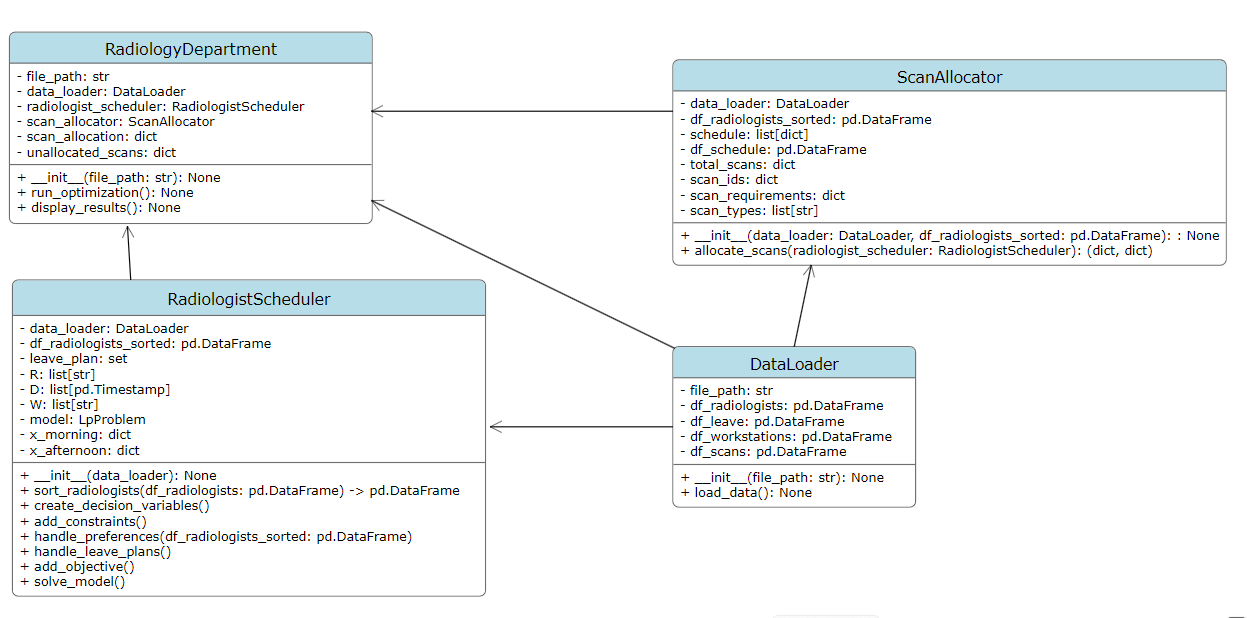